# Preface

As a relatively new programmer I have only used python as a tool for Data Structures and Algorithms problems. However, we know Python's true prowess lies in many things,  including Data Analysis and Machine Learning. So I decided to scour the internet on something cool to analyze. 

Not long after, I happen to chance upon Tom Ewing's presentation on Visualizing Location Data with Python and KeplerGL . The visualization with KeplerGL was mesmerizing and seemed relatively straightforward. 

Thus I decided to give it a shot following his work. This blog post is a culmination of what I've learnt throughout this journey. I do not claim any credit for the work he has done.

# Setting Up

<h3><b>Dataset</b></h3>

The dataset used in the tutorial pertained to Traffic Accidents in the UK. I tried to look for a similar dataset (not completely the same) just so that I can see if I can verify if the underlying concepts and methods are applicable. 

However, I tried to search for datasets that are similar to the theme of traffic accidents so I don't stray too far off.

As far as I know, the geospatial datasets need to contain both `longitudes` and `latitudes`. I combed through various google search pages, and did not expect the difficulty involved in  Turns out that geospatial data with longitudes and latitudes is usually hard to come by.

Luckily, Kaggle has a dataset on [US Accidents](https://www.kaggle.com/sobhanmoosavi/us-accidents) which contains 4.2 million records (the dataset is about 1.5GB), which covers 49 states of the USA, collected from February 2016 to December 2020.

<h3><b>Google Cloud Platform (AI Notebook)</b></h3>

Enter Google Cloud Platform (GCP). GCP is a suite of cloud computing services that Google offers. In particular, it offers this service known as AI Notebook, which provides managed JupyterLab instances that allows users like myself to experiment, develop and deploy models into production. 

New users of GCP get $300 free credits for 90 days, which was very timely for me in respect to my little project.

GCP's AI Notebook also comes with the option to choose the kinds of compute instances to use, which is great for me as I tried to cut down on the data processing time on the 1.5GB dataset. In my case, I experimented with the `Machine Type` of  `6 vCPUs, 60GB RAM` against the default `2vCPUs 2 GB RAM`. Of course, the higher the computing power, the higher the costs.

Due to the nature of my code, it only decreased my processing time by about 20-30%. In one of the steps, the estimated time required was 7 hours but was reduced to around 5 hours.

<h3><b>Datalab vs AI Notebook</b></h3>
    
AI Notebook is effectively  an upgraded version of GCP's Datalab and use the notebook directly through your browser. Hence, it is almost recommended to use AI Notebook instead.

AI Notebook supports the the URI links to the files stored on Google Cloud Storage in the format of `gs://<bucket_name>/<file_path_to_object>`. This effectively compartmentalizes all the code and datasets in one place.
In my experiments with Datalab, it does not support this functionality.

To access the bucket in Jupyter, simply activate by entering `gcloud init` in the Jupyter notebook terminal.


<h1>Geospatial Data Concepts</h1>

<b>Introduction to GIS Concepts</b>

These concepts are introduced in said tutorial as well. Just adding some more details to note when working with Geospatial data.

<b> Geographic Information System (GIS) </b>

"A Geographic Information System (GIS) is an information system that allows for mapping, querying, modeling and analyzing of data based on location"
Source: https://www.jacksongov.org/250/What-GIS-Is-Purpose

Commonly used GIS: ArcGIS, QGIS

To put in context - Google Maps is somewhat considered as a GIS Map as you can  use it to map out various landmarks and topographic features. 

But some people oppose this view as it does not highlight all the geographic features in a region and their interaction with other features.

This is not so pertinent for this project, but its good to know.

Read more: [https://www.geo-tel.com/gis-map-google-maps/](https://www.geo-tel.com/gis-map-google-maps/)

<b>Co-ordinate Reference System(CRS)</b>

"A coordinate reference system (CRS) refers to the way in which spatial data that represent the earth’s surface (which is round / 3 dimensional) are flattened so that you can “Draw” them on a 2-dimensional surface."

Source: https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/intro-to-coordinate-reference-systems/

Because the Earth is spheroid (ellipisoid) and not completely round in nature, it is not possible to completely draw/project it in a 2D format, without stretching some parts of the map. Different methods of flattening the maps resulted in different map projections. Most famous projection is Mercator.


# Starting To Code

We will use gdf_rs to refer to the data and gdf_map as the map, following the tutorial.
We first activate tqdm to work with pandas
https://towardsdatascience.com/progress-bars-in-python-4b44e8a4c482

In [49]:
from tqdm.auto import tqdm
tqdm.pandas()

1. We store the dataset onto Google Cloud Storage on GCP for easy access. This then allows AI Notebook to read the file directly without storing on our local computer.

2. Attribute low_memory=False
"Internally process the file in chunks, resulting in lower memory use while parsing, but possibly mixed type inference. To ensure no mixed types either set False, or specify the type with the dtype parameter. Note that the entire file is read into a single DataFrame regardless, use the chunksize or iterator parameter to return the data in chunks. (Only valid with C parser)."
Adapted from: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html


According to this Stackoverflow answer: https://stackoverflow.com/questions/25488675/mixed-types-when-reading-csv-files-causes-fixes-and-consequences

When Pandas tries to read the file, it reads in chunk, and hence tries to infer the datatype (dtype) in each chunk, thus possibly resulting in inconsistent dtypes. In order to prevent this, low_memory=False forces Pandas to read the whole file first before deciding on the type.

3. %store df_rs()
This know as a Magic Command that IPython provides. It simply stores the results into the file and can be re-read next time by performing `%store -r df_rs()`

In [51]:
import pandas as pd
df_rs = pd.read_csv(
    'gs://kepler_gl_2/US_Accidents_Dec20.csv',
    low_memory=False
)

df_rs.head()
%store df_rs

Stored 'df_rs' (DataFrame)


Since the data set comprises 49 columns and not are relevant, we select only the columns that are relevant to this project.

Here, we remove rows with missing values in the Start_Lat and Start_Lng columns using the pandas dropna method.


In [53]:
#Selecting only the columns that we need out of 49 ou
df_rs = df_rs[['ID','Severity','Start_Time','Start_Lat','Start_Lng','Description']]

#clears all the empty cells in lat and long
df_rs.dropna(subset=['Start_Lat','Start_Lng'])

%store df_rs

Stored 'df_rs' (DataFrame)


Creating a GeoDataFrame from the GeoPandas documentation:

A GeoDataFrame needs a shapely object. We use geopandas points_from_xy() to transform Longitude and Latitude into a list of shapely.Point objects and set it as a geometry while creating the GeoDataFrame. (note that points_from_xy() is an enhanced wrapper for [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)])
https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html

This is why it is imperative we use x as the longitude and y as the latitude.

In [55]:
import geopandas as gpd

#Make the GeoDataFrame

gdf_rs = gpd.GeoDataFrame(
df_rs,
geometry=gpd.points_from_xy(
x=df_rs['Start_Lng'],
y=df_rs['Start_Lat']))


In [57]:
%store gdf_rs

Stored 'gdf_rs' (GeoDataFrame)


Intermediate step to read from our existing df_rs and gdf_rs variables if reloaded the page. This is to speed up the development process.

In [59]:
#read from store
# %store -r df_rs
# %store -r gdf_rs

The .head() method is displays the first 5 rows of the DataFrame. A quick and easy way to see some data without loading all of it.

In [61]:
#Show the DataFrame
gdf_rs.head()

,ID,Severity,Start_Time,Start_Lat,Start_Lng,Description,geometry
0,A-1,3,2016-02-08 05:46:00,39.865147,-84.058723,Right lane blocked due to accident on I-70 Eas...,POINT (-84.05872 39.86515)
1,A-2,2,2016-02-08 06:07:59,39.928059,-82.831184,Accident on Brice Rd at Tussing Rd. Expect del...,POINT (-82.83118 39.92806)
2,A-3,2,2016-02-08 06:49:27,39.063148,-84.032608,Accident on OH-32 State Route 32 Westbound at ...,POINT (-84.03261 39.06315)
3,A-4,3,2016-02-08 07:23:34,39.747753,-84.205582,Accident on I-75 Southbound at Exits 52 52B US...,POINT (-84.20558 39.74775)
4,A-5,2,2016-02-08 07:39:07,39.627781,-84.188354,Accident on McEwen Rd at OH-725 Miamisburg Cen...,POINT (-84.18835 39.62778)


In [63]:
# Print the type of the geometry column
print(type(gdf_rs['geometry'][0]))

<class 'shapely.geometry.point.Point'>


1. For similar reasons as mentioned in the tutorial, the new method of doing `<authorty>:<code>` is buggy and does not work. Using `init = <authority>:<code>` is therefore preferred.

2. EPSG stands for European Petroleum Survey Group Geodetic Parameter Dataset. The group publishes a database of coordinate system information and some good related documents on map projections and datum. 

For simplicity sake, geodetic datum refers a system used for precisely measuring locations on Earth or other planetary body.

In summary, EPSG codes are 4-5 digit numnbers that represent CRS' definitions.

Here, we initialize the EPSG to 2163 which is the US national Atlas Equal Area coordinate system, for projection onto our map later on.

3. It is also useful to recognize the WKT or Well-Known Text format as some tools also represents CRS definitions using a combination of brackets [] and elements separated by commas(,).
https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/spatial-data-vector-shapefiles/epsg-proj4-coordinate-reference-system-formats-python/

In [65]:
# Set the CRS
gdf_rs.crs = {'init':'epsg:2163'}
gdf_rs.crs

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - onshore and offshore.
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

Here we follow the same method to get the map data in the tutorial and set the CRS to the same value in order for the points to be plotted.

The map obtained in this walkthrough is from https://www.statsilk.com/maps/download-free-shapefile-maps

MapShaper also helps to reduce the size of the map files. This can be done by reducing the fidelity of the maps uploaded.
https://mapshaper.org/

After which, this converts the map data into a json file format, ready to be converted into a GeoDataFrame.

In [67]:
#Create geodataframe
gdf_map = gpd.read_file('gs://kepler_gl_2/map.json')

#Set the CRS #must use the old way for it to work
gdf_map.crs = {'init':'epsg:2163'}

#Check the CRS
gdf_map.crs

<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - onshore and offshore.
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

In [69]:
gdf_map.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,20,175,00485050,0500000US20175,20175,Seward,06,1655865960,2777350,"POLYGON ((-101.06790 37.38778, -101.06645 36.9..."
1,28,141,00695791,0500000US28141,28141,Tishomingo,06,1098939230,52359814,"POLYGON ((-88.36353 34.99575, -88.36547 34.755..."
2,36,101,00974148,0500000US36101,36101,Steuben,06,3601566799,34993606,"POLYGON ((-77.72296 42.47122, -77.74993 41.998..."
3,50,013,01461763,0500000US50013,50013,Grand Isle,06,211894597,292303559,"POLYGON ((-73.34312 45.01084, -73.36268 44.562..."
4,05,065,00066860,0500000US05065,05065,Izard,06,1503685418,8912603,"POLYGON ((-92.15699 36.26125, -92.19543 36.132..."


This is the first time we plot the US map! 

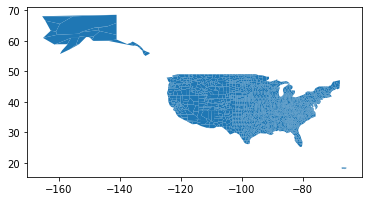

In [71]:
#Plot the map
gdf_map.plot();

However, according to details of the dataset, we know that it does not cover Alaska. Hence we can remove it from the plot by referencing `STATEFP`, which refers to the the State FIPS Codes. Each US State has a unique code, and Alaska's is 02.

The ~ before gdf_map... is negation (similar to NOT bitwise operator) in numpy.

See: https://smoosavi.org/datasets/us_accidents
https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696
https://stackoverflow.com/questions/35186291/how-do-i-delete-rows-not-starting-with-x-in-pandas-or-keep-rows-starting-with

In [73]:
#Remove Alaska from the map
gdf_map=gdf_map[
    ~gdf_map['STATEFP'].str.startswith('02')
]

In [75]:
#Convert the CRS of GDF Map
gdf_map = gdf_map.to_crs(epsg='4326')

#Check the CRS
gdf_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

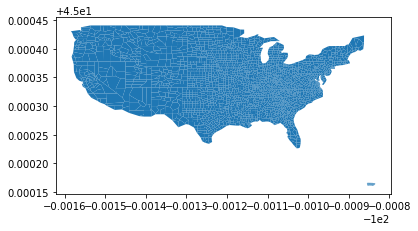

In [77]:
#Plot the map
gdf_map.plot()

Note that when the CRS has been changed, the scales have changed as well.
*Still investigating why the axes are not reflective of the bounds  as seen in the gdf_map.crs variable

From the tutorial:
1. The geometry column contains Shapely POLYGON and MULTIPOLYGON objects.
2. Note the axis scale of the map
3. The map also has Lon / Lat coordinates in it but we can't use these in our geometry column as they'll make a POINT and not a POLYGON or MULTIPOLYGON
4. So we have to convert the CRS so that gdf_map DataFrame has the same CRS as the gdf_rs DataFrame.

In [79]:
def plot_map_1():
# Plot a map and data (plot on basemap)
# Base map
    base_map = gdf_map.plot(
    color="white",
    edgecolor = 'grey',
    linewidth=0.5,
    figsize=(15,8),        
    legend=True
    )
    base_map.axis('off')
    base_map.set_title('US Road Traffic Accidents till 2020')
    
    gdf_rs.plot(ax=base_map);

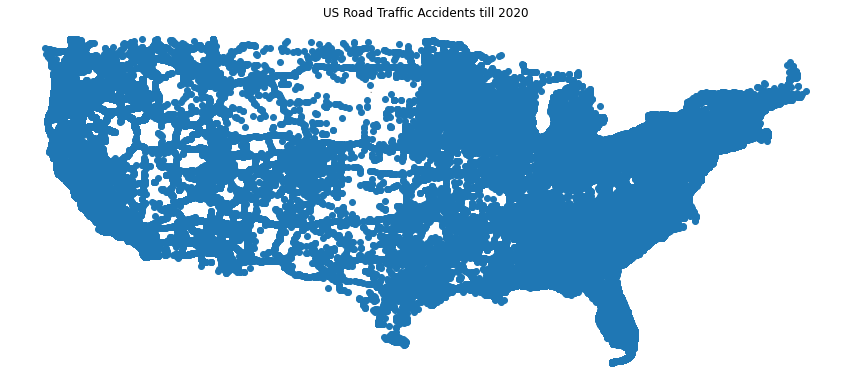

In [81]:
plot_map_1()

The map in map_1 has a clearer silhoulette, but it is still very hard to discern where the accidents reside.
We attempt to plot a clearer map using the Mercator projection below.

In retrospective, we may not have had to use a different projection as the distortion between epsg 4326 and epsg 3857 was not significant. The key to perhaps plotting a clearer map might have been to 
1.adjust the figsize in the basemap to a smaller scale
2.use a smaller markersize

In [83]:
# Plotting a nicer map using Mercator projections (epsg = 3857)
# https://source.opennews.org/articles/choosing-right-map-projection/
def plot_map_2():
    #Base Map
    base_map = gdf_map.to_crs(epsg='3857').plot(
        color='white',
        edgecolor='grey',
        linewidth=0.5,
        figsize=(10,10),
        legend=True
    )
    
    base_map.axis('off')
    base_map.set_title('US Road Traffic Accidents until 2020')

    #Data
    gdf_rs.to_crs(epsg='3857').plot(
        ax=base_map,
        markersize=0.2,
        color='red'
    );


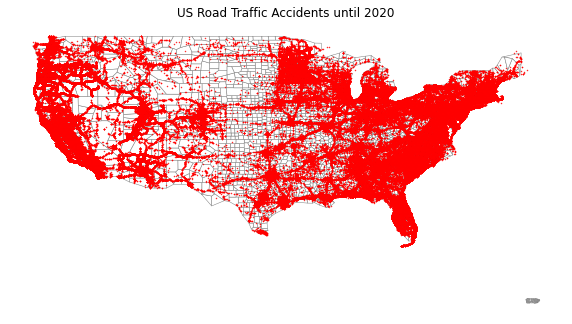

In [85]:
plot_map_2()

Note that the crs for both the map (gdf_map) and the data (gdf_rs) remain out of sync.
The `to_crs()` method does not mutate gdf_map or gdf_rs. Currently, the `crs` attribute of both gdf_map and gdf_rs are still mismatched at epsg: 4326 and epsg: 2163 respectively. 

Hence we convert both into epsg 2163 for consistency (US National Atlas).

In [87]:
gdf_rs.crs

<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - onshore and offshore.
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

In [88]:
gdf_map.crs

<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - onshore and offshore.
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

In [89]:
gdf_map = gdf_map.to_crs(epsg='2163')

#Checking crs to make sure they are aligned
print(gdf_map.crs,'gdf_map_crs')
print(gdf_rs.crs,'gdf_rs_crs')

epsg:2163 gdf_map_crs
+init=epsg:2163 +type=crs gdf_rs_crs


In [90]:
%store gdf_map
%store gdf_rs

Stored 'gdf_map' (GeoDataFrame)
Stored 'gdf_rs' (GeoDataFrame)


In this step, we have to match the geometric points in our accidents data to the map. 

What we will do is we will loop through for each incident and check it against each state inside our map. 

If the point resides within the state we will save that into a separate output list. 
This list will have the corresponding state matched to each incident.

Here, we also use the `tqdm` library to show us how long the process will take.

Note that

1. .to_dict(orient='records') is a pandas method, where we convert the dataframe into a list like [{column -> value}, … , {column -> value}] format. I.e it will be a list of [{STATEFP: GEOMETRY}...]
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html


2. `.within()` is a function extended from shapely and not native to geopandas.
https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html



In [93]:
#Convert DataFrames to dictionaries for iteration
map_dict = gdf_map[['STATEFP','geometry']].to_dict(orient='records')
rs_dict = gdf_rs[['ID','geometry']].to_dict(orient='records')

#Empty list to assign output dictionaries to
rs_output_list = []

for incident in tqdm(rs_dict):
    #Make a copy of the input incident
    output_dict = incident.copy()
    
    #For each STATE, we check whether the incident is located inside its polygon.
    #If it does, assign the STATEFP and append to the rs_output_list & break the loop
    
    for state in map_dict:                
        if state['geometry'] is not None and incident['geometry'].within(state['geometry']):           
            output_dict['STATEFP'] = state['STATEFP']
            rs_output_list.append(output_dict)
            break
        else:
            pass

  0%|          | 0/4232541 [00:00<?, ?it/s]

In [94]:
#Store the rs_output_list after 5-6 hours of computation!!
%store rs_output_list

Stored 'rs_output_list' (list)


In [92]:
%store -r gdf_rs
%store -r gdf_map
# %store -r rs_output_list

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [95]:
#Check if rs_output_list contains geometries
print(rs_output_list[1])

{'ID': 'A-2', 'geometry': <shapely.geometry.point.Point object at 0x7f729f081990>, 'STATEFP': '39'}


# Making the Choropleth

Choropleth Maps display divided geographical areas or regions that are coloured, shaded or patterned in relation to a data variable. They are similiar to heatmaps.

With the incidents mapped to the states, we can now perform a left outer join between the accident data (left) and the output_list (right) to merge back the STATEFP data for each incident, into the GeoDataFrame. This is done using pandas' pd.merge.

We also create a new column called "Incidents" and assign each incident(row) a value of 1.

In [96]:
gdf_ch = pd.merge(
    left=gdf_rs,
    right=pd.DataFrame(rs_output_list).drop('geometry', axis=1),
    on='ID',
    how='left'
)

gdf_ch['Incidents'] = 1
gdf_ch.head()

%store gdf_ch

Stored 'gdf_ch' (GeoDataFrame)


In [97]:
#Check the output of gdf_ch
gdf_ch.head()

,ID,Severity,Start_Time,Start_Lat,Start_Lng,Description,geometry,STATEFP,Incidents
0,A-1,3,2016-02-08 05:46:00,39.865147,-84.058723,Right lane blocked due to accident on I-70 Eas...,POINT (-84.05872 39.86515),39,1
1,A-2,2,2016-02-08 06:07:59,39.928059,-82.831184,Accident on Brice Rd at Tussing Rd. Expect del...,POINT (-82.83118 39.92806),39,1
2,A-3,2,2016-02-08 06:49:27,39.063148,-84.032608,Accident on OH-32 State Route 32 Westbound at ...,POINT (-84.03261 39.06315),39,1
3,A-4,3,2016-02-08 07:23:34,39.747753,-84.205582,Accident on I-75 Southbound at Exits 52 52B US...,POINT (-84.20558 39.74775),39,1
4,A-5,2,2016-02-08 07:39:07,39.627781,-84.188354,Accident on McEwen Rd at OH-725 Miamisburg Cen...,POINT (-84.18835 39.62778),39,1


Here we want to consolidate all of the incidents in each state together using pandas' .groupby() method. We can think of this as a split-apply-combine technique.

<b> Split </b>

We first select the STATEFP and Incidents column, before splitting this dataframe (consisting of only these 2 columns) up into smaller tables containing individual states. 

<b> Apply </b>

After which, we apply an operation on each of these tables, using the .sum() function.
We also reset the index() of the dataframe. Not sure why we need to do this at the moment.

<b> Combine </b>

The groupby function then combines all the resultant tables into one.

In [98]:
# Groupby
gdf_ch = (
    gdf_ch[['STATEFP', 'Incidents']]
    .groupby(['STATEFP'])
    .sum()
    .reset_index()
)

# Merge
gdf_ch = (
    pd.merge(
        left=gdf_map[['STATEFP', 'geometry']],
        right=gdf_ch,
        on='STATEFP',
        how='left'
    )
    # original implementation was to fill missing geometries with 0. but that has led to an error
    # https://github.com/geopandas/geopandas/issues/1149
    .dropna()
)


In [99]:
gdf_ch.head()

,STATEFP,geometry,Incidents
0,20,"POLYGON ((-101.06790 37.38778, -101.06645 36.9...",9865.0
1,28,"POLYGON ((-88.36353 34.99575, -88.36547 34.755...",8051.0
2,36,"POLYGON ((-77.72296 42.47122, -77.74993 41.998...",175584.0
3,50,"POLYGON ((-73.34312 45.01084, -73.36268 44.562...",863.0
4,05,"POLYGON ((-92.15699 36.26125, -92.19543 36.132...",4801.0


In [100]:
%store gdf_ch

Stored 'gdf_ch' (GeoDataFrame)


In [ ]:
# %store -r gdf_ch

<AxesSubplot:>

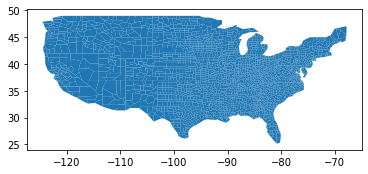

In [101]:
gdf_ch.plot()

In order to display classify the frequencies of incidents, we have to apply the concept of 'binning'. 

Simply put, we classify a range of numbers and count the frequency of incidents that happen inside this interval.

In [102]:
#Binning with MapClassify
import mapclassify
# https://geographicdata.science/book/notebooks/05_choropleth.html
scheme = mapclassify.Quantiles(gdf_ch['Incidents'], k=30)
scheme

/opt/conda/lib/python3.7/site-packages/mapclassify/classifiers.py:235: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/opt/conda/lib/python3.7/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: setting k to 28
  Warn("Warning: setting k to %d" % k_q, UserWarning)


Quantiles                     

       Interval          Count
------------------------------
[   226.00,    463.00] |   119
(   463.00,   3328.00] |   109
(  3328.00,   4347.00] |   100
(  4347.00,   6569.00] |   108
(  6569.00,   8051.00] |    85
(  8051.00,   9865.00] |   115
(  9865.00,  13901.00] |   120
( 13901.00,  21641.00] |    71
( 21641.00,  24796.00] |   120
( 24796.00,  24997.00] |    93
( 24997.00,  38374.00] |   100
( 38374.00,  38869.00] |   115
( 38869.00,  54027.00] |    76
( 54027.00,  64860.00] |   173
( 64860.00,  72821.00] |   109
( 72821.00,  72854.00] |    37
( 72854.00,  88762.00] |   182
( 88762.00,  93193.00] |    15
( 93193.00, 105355.00] |   167
(105355.00, 105800.00] |    36
(105800.00, 106218.00] |   159
(106218.00, 112368.00] |   102
(112368.00, 125368.00] |   105
(125368.00, 137012.00] |    67
(137012.00, 193085.00] |   161
(193085.00, 213809.00] |    46
(213809.00, 376217.00] |   321
(376217.00, 880553.00] |    56

In [112]:
import geoplot

def plot_choropleth():
    ax = geoplot.choropleth(
        df=gdf_ch,
        hue=gdf_ch['Incidents'], 
        cmap='Reds',
        scheme=scheme,
        legend=True,
        linewidth=0,
        figsize=(20,20)
    )

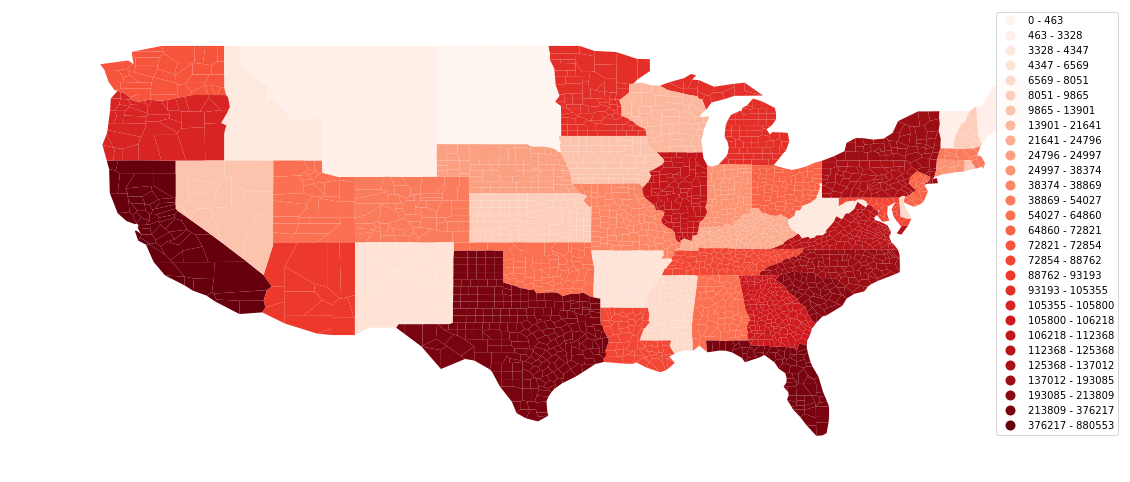

In [113]:
plot_choropleth()

The final chart looks like a heatmap, where we can see the traffic accidents in each state has a different shade of red, as per the classification.

A key takeaway is that the darker red areas appears to correspond to more populous areas. 
This can be confirmed with a further study between this chart and the US population can be conducted to see if this relationship is true.

# Conclusion

This mini-project has been interesting in learning more about geospatial projections and trying out GCP, GeoPandas and Geoplot.

Future implementations of this would include rendering the choropleth onto `KeplerGL`, a library that enables 3D visualization on the browser. 

There are currently some technical difficulties surrounding this, and I will provide a update to this in the future.

Key Learning points for me:
1. Using GCP / AI notebook to process large amounts of data
2. Learning about the workings of Pandas, GeoPandas and Geoplot in terms of data manipulation
3. Understanding Geospatial terms like CRS and projections that happen under the hood.


Credits to Tom Ewing for making the tutorial referenced throughout this project once again.